# Background Fits

In [1]:
import tensorflow as tf
import zfit
from zfit import z
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

2022-04-06 09:44:22.622435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-06 09:44:22.622498: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


# Gather Data

In [2]:
preselected = pd.read_csv('../data_files/9.1.4/all.csv', index_col=[0])
preselected = preselected['Lb_M'][np.logical_and(preselected['category'] == 0, preselected['IsSimulated'] == False)].to_numpy()
# Only keep the background events

nopreselected = pd.read_csv('../data_files/9.1.1/all.csv', index_col=[0])
nopreselected = nopreselected[np.logical_or(nopreselected['Lb_M'].between(4600, 5200), nopreselected['Lb_M'].between(5800, 6400))]
# Apply the mass range restriction as it has not been done 
nopreselected = nopreselected['Lb_M'][nopreselected['category'] == 0].to_numpy()
# Only keep the background events

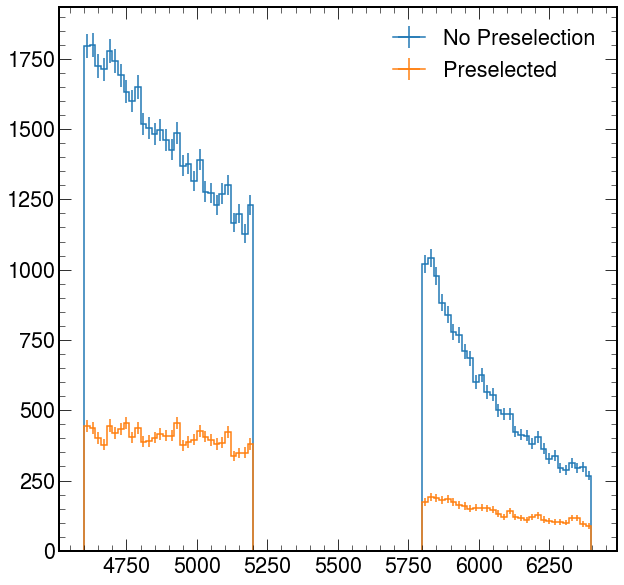

In [5]:
fig, ax = plt.subplots(1, 1)
fpre, bins = np.histogram(preselected, bins=90)
fnpre, _ = np.histogram(nopreselected, bins=bins)
hep.histplot([fnpre, fpre], bins=bins, yerr=True, ax=ax, label=['No Preselection', 'Preselected'])
plt.legend()
plt.show()

# Perform Fits

In [9]:
# Create custom second and third order polynomials
class MyQuadratic(zfit.pdf.ZPDF):
    _N_OBS = 1
    _PARAMS = ['p0', 'p1', 'p2', 'shift']  # name of the parameters

    def _unnormalized_pdf(self, x):
       x = z.unstack_x(x)
       p0 = self.params['p0']
       p1 = self.params['p1']
       p2 = self.params['p2']
       shift = self.params['shift']
       return p2*(x-shift)**2 + p1*(x-shift) + p0
    
class MyCubic(zfit.pdf.ZPDF):
    _PARAMS = ['p0', 'p1', 'p2', 'p3', 'shift']

    def _unnormalized_pdf(self, x):
       x = z.unstack_x(x)
       p0 = self.params['p0']
       p1 = self.params['p1']
       p2 = self.params['p2']
       p3 = self.params['p3']
       shift = self.params['shift']
       return p3*(x-shift)**3 + p2*(x-shift)**2 + p1*(x-shift) + p0
   
def QuadraticIntegral(limits, params, model):
   (lower,), (upper,) = limits.limits
   p1 = params['p1']
   p2 = params['p2']
   return 2*p2*(upper - lower)

def CubicIntegral(limits, params, model):
   (lower,), (upper,) = limits.limits
   p1 = params['p1']
   p2 = params['p2']
   p3 = params['p3']
   shift = params['shift']
   return (3*p3*(upper-shift)**2 + 2*p2*upper) - (3*p3*(lower-shift)**2 + 2*p2*lower)

# Register the integrals
limits = zfit.Space.from_axes(axes=0, limits=(zfit.Space.ANY_LOWER, zfit.Space.ANY_UPPER))
MyQuadratic.register_analytic_integral(func=QuadraticIntegral, limits=limits)
MyCubic.register_analytic_integral(func=CubicIntegral, limits=limits)

In [33]:
def fitCub(np_data, label, param_ranges, mass_ranges=[4600, 5200, 5800, 6400]):
    lowerSB = zfit.Space("Lb_M",(mass_ranges[0],mass_ranges[1]))
    upperSB = zfit.Space("Lb_M",(mass_ranges[2],mass_ranges[3]))
    massSbSpace = lowerSB + upperSB
    
    LbM = zfit.Data.from_numpy(obs=massSbSpace, array=np_data)
    
    p3 = zfit.Parameter('p3_%s'%label, *param_ranges[0])
    p2 = zfit.Parameter('p2_%s'%label, *param_ranges[1])
    p1 = zfit.Parameter('p1_%s'%label, *param_ranges[2])
    p0 = zfit.Parameter('p0_%s'%label, *param_ranges[3])
    shift = zfit.Parameter('shift_%s'%label, *param_ranges[4])
    
    cubic = MyCubic(obs=massSbSpace, p0=p0, p1=p1, p2=p2, p3=p3, shift=shift)
    
    cubic_yield = zfit.Parameter('yield_%s'%label, *param_ranges[5], step_size=1)
    cubic_ext = cubic.create_extended(cubic_yield)
    nll_ext_dcb = zfit.loss.ExtendedUnbinnedNLL(cubic_ext, LbM)
    minimizerDCB = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult = minimizerDCB.minimize(nll_ext_dcb)
    
    return cubic_ext, fitResult, LbM

def fitQuad(np_data, label, param_ranges, mass_ranges=[4600, 5200, 5800, 6400]):
    lowerSB = zfit.Space("Lb_M",(mass_ranges[0],mass_ranges[1]))
    upperSB = zfit.Space("Lb_M",(mass_ranges[2],mass_ranges[3]))
    massSbSpace = lowerSB + upperSB
    
    LbM = zfit.Data.from_numpy(obs=massSbSpace, array=np_data)
    
    p2 = zfit.Parameter('p2_%s'%label, *param_ranges[0])
    p1 = zfit.Parameter('p1_%s'%label, *param_ranges[1])
    p0 = zfit.Parameter('p0_%s'%label, *param_ranges[2])
    shift = zfit.Parameter('shift_%s'%label, *param_ranges[3])
    
    cubic = MyQuadratic(obs=massSbSpace, p0=p0, p1=p1, p2=p2, shift=shift)
    
    cubic_yield = zfit.Parameter('yield_%s'%label, *param_ranges[4], step_size=1)
    cubic_ext = cubic.create_extended(cubic_yield)
    nll_ext_dcb = zfit.loss.ExtendedUnbinnedNLL(cubic_ext, LbM)
    minimizerDCB = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult = minimizerDCB.minimize(nll_ext_dcb)
    
    return cubic_ext, fitResult, LbM

def fitExp(np_data ,label, param_ranges=[[1000,0,1e6],[-0.1,-1,0]], mass_ranges=[4600, 5200, 5800, 6400]):
    lowerSB=zfit.Space("Lb_M",(mass_ranges[0],mass_ranges[1]))
    upperSB=zfit.Space("Lb_M",(mass_ranges[2],mass_ranges[3]))
    massSbSpace=lowerSB+upperSB

    SbData_LbM=zfit.Data.from_numpy(obs=massSbSpace, array=np_data)
    exp_yield = zfit.Parameter('exp_yield_%s'%label,*param_ranges[0],step_size=1)
    exp_lamb = zfit.Parameter("lambda_%s"%label,*param_ranges[1])

    expModel = zfit.pdf.Exponential(obs=massSbSpace, lam=exp_lamb)
    expModel_ext=expModel.create_extended(exp_yield)
    nll_ext= zfit.loss.ExtendedUnbinnedNLL(expModel_ext,SbData_LbM)
    minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult=minimizer.minimize(nll_ext)
    
    return expModel_ext, fitResult, SbData_LbM

def fitGaussExp(np_data ,label, param_ranges=[[1000,0,1e6],[-0.1,-1,0], [4500, 4000, 6000], [100, 1, 2000]], mass_ranges=[4600, 5200, 5800, 6400]):
    lowerSB=zfit.Space("Lb_M",(mass_ranges[0],mass_ranges[1]))
    upperSB=zfit.Space("Lb_M",(mass_ranges[2],mass_ranges[3]))
    massSbSpace=lowerSB+upperSB

    SbData_LbM=zfit.Data.from_numpy(obs=massSbSpace, array=np_data)
    exp_yield = zfit.Parameter('exp_yield_%s'%label,*param_ranges[0],step_size=1)
    exp_lamb = zfit.Parameter("lambda_%s"%label,*param_ranges[1])
    mu = zfit.Parameter("mu_%s"%label, *param_ranges[2])
    sigma = zfit.Parameter("sigma_%s"%label, *param_ranges[3])

    expModel = zfit.pdf.Exponential(obs=massSbSpace, lam=exp_lamb)
    Gaussian = zfit.pdf.Gauss(obs=massSbSpace, mu=mu, sigma=sigma)
    composite = zfit.pdf.ProductPDF(pdfs=[expModel, Gaussian]) 
    
    composite_ext = composite.create_extended(exp_yield)
    nll_ext= zfit.loss.ExtendedUnbinnedNLL(composite_ext, SbData_LbM)
    minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult=minimizer.minimize(nll_ext)
    
    return composite_ext, fitResult, SbData_LbM

In [14]:
model, result, LbM = fitExp(preselected, "1")

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/core/integration.py:499: UserWarning: Multispace limits compare never equal to Space.
  if integ.limits >= limits


In [20]:
cubic, cubic_result, masses = fitCub(preselected, "Pre", param_ranges=[[0, -1, 3], [0, -2, 2], [-0.2, -5, 5],  [200, 100, 300], [5500, 4500, 6500], [10000, 0, 30000]])

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/core/integration.py:499: UserWarning: Multispace limits compare never equal to Space.
  if integ.limits >= limits


In [30]:
quad, quad_result, masses = fitQuad(preselected, "Quad", param_ranges=[[0, -2, 2], [-0.2, -5, 5],  [200, 100, 300], [5500, 4500, 6500], [10000, 0, 30000]])

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/core/integration.py:499: UserWarning: Multispace limits compare never equal to Space.
  if integ.limits >= limits


## Evaluate Fit

In [31]:
quad_param_errors = quad_result.errors()
print(f"Converged: {quad_result.converged}\nValid: {quad_result.valid}\n")
print(quad_result.params)

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/minimizers/fitresult.py:1115: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


Converged: True
Valid: True

name            value         minuit_minos    at limit
----------  ---------  -------------------  ----------
yield_Quad      16170  -1.3e+02   +1.3e+02       False
p0_Quad         214.5  -     57   +     86       False
p1_Quad       -0.1879  -  0.058   +  0.058       False
p2_Quad     1.009e-05  -8.6e-06   +8.4e-05       False
shift_Quad       5598  -1.1e+03   +  9e+02       False


In [23]:
cubic_param_errors = cubic_result.errors()
print(f"Converged: {cubic_result.converged}\nValid: {cubic_result.valid}\n")
print(cubic_result.params)

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/minimizers/fitresult.py:1115: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
Converged: True
Valid: True

name            value         minuit_minos    at limit
---------  ----------  -------------------  ----------
yield_Pre       16160  -1.2e+02   +1.2e+02       False
p0_Pre          292.6  -     11   +    7.1       False
p1_Pre        -0.2944  - 0.0074   + 0.0074       False
p2_Pre      1.408e-05  -1.2e-05   +1.4e-05       False
p3_Pre     -1.152e-09  -2.5e-09   +  1e-09       False
shift_Pre        5763  -     26   +     39       False


In [43]:
cubic_result.params["yield_Pre"]

{'value': 16159.713459076758,
 'minuit_minos': {'lower': -124.61833814172405,
  'upper': 124.61833814172405,
  'is_valid': False,
  'upper_valid': False,
  'lower_valid': False,
  'at_lower_limit': False,
  'at_upper_limit': False,
  'nfcn': 56,
  'original': ┌──────────┬───────────────────────┐
│          │       yield_Pre       │
├──────────┼───────────┬───────────┤
│  Error   │  -0.12e3  │  0.12e3   │
│  Valid   │   False   │   False   │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘,
  'cl': 0.68268949}}

In [16]:
param_errors = result.errors()
print(f"Converged: {result.converged}\nValid: {result.valid}\n")
print(result.params)

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/minimizers/fitresult.py:1115: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


Converged: True
Valid: True

name              value         minuit_minos    at limit
-----------  ----------  -------------------  ----------
exp_yield_1       16170  -1.3e+02   +1.3e+02       False
lambda_1     -0.0008659  -1.4e-05   +1.4e-05       False


/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/core/integration.py:499: UserWarning: Multispace limits compare never equal to Space.
  if integ.limits >= limits
/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/core/integration.py:499: UserWarning: Multispace limits compare never equal to Space.
  if integ.limits >= limits
/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/core/integration.py:499: UserWarning: Multispace limits compare never equal to Space.
  if integ.limits >= limits


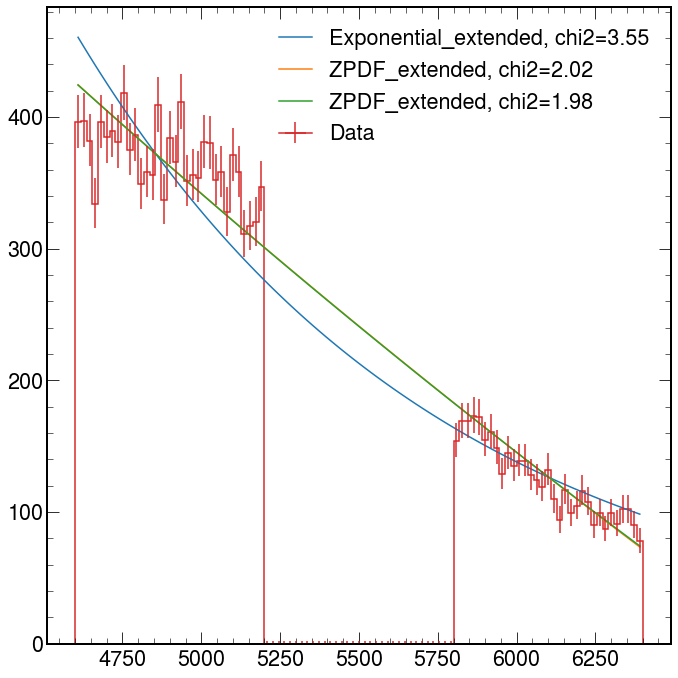

In [36]:
fig, ax = plt.subplots(1, 1)
for m, data in zip([model, cubic, quad], [LbM, masses, masses]):
    allLimits=[]
    if data.space.n_limits>1:
        xBins=np.array([])
        for i in data.space:
            allLimits.append(i.limit1d[0])
            allLimits.append(i.limit1d[1])
    else:
        allLimits.append(data.data_range.limit1d[0])
        allLimits.append(data.data_range.limit1d[1])
        
    allLimits=np.array(allLimits)

    xBins = np.linspace(np.amin(allLimits), np.amax(allLimits), num=100)
    x=(xBins[1:]+xBins[:-1])/2
    y=np.array([])
    nBinsLimit=0

    for a in range(int(allLimits.shape[0]/2)):
        nBinsLimit+=len(x[(x>allLimits[a*2])&(x<allLimits[a*2+1])])
        
    y = np.append(y, m.pdf(x) * data.nevents.numpy() / nBinsLimit * np.sum(allLimits[1::2]-allLimits[::2]))

    data_plot = zfit.run(z.unstack_x(data))
    a = np.histogram(data_plot, bins=xBins)

    scaledDiff=(a[0][a[0]!=0]-y[a[0]!=0])/np.sqrt(a[0][a[0]!=0])
    chi2 = np.sum(scaledDiff**2)/(len(scaledDiff)-len(m.get_params()))
    
    ax.plot(x, y,label=f"{m.name}, chi2={chi2:.2f}")
    
data_plot = zfit.run(z.unstack_x(masses))
h, bins = np.histogram(data_plot, bins=xBins)
hep.histplot(h, bins, ax=ax, yerr=True, label='Data')
plt.legend()
plt.tight_layout()
plt.show()